In [0]:
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Activation, RepeatVector
from tensorflow.keras.layers import Permute, multiply, Lambda, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import LambdaCallback
from keras import backend as K

from tensorflow.keras import optimizers

import tensorflow as tf

from sklearn.utils import class_weight

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import random
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

import time
import math

In [0]:
# Helper function to plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
# Precision = TP / (TP+FP).
def precision(decoded_vals, target_vals):
    TP = 0
    FP = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
        FP += int(decoded_vals[i] == 0 and target_vals[i] == 1)

    return 1.0 * TP / (TP + FP)

# Recall = TP / (TP+FN).
def recall(decoded_vals, target_vals):
    TP = 0
    FN = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
        FN += int(decoded_vals[i] == 1 and target_vals[i] == 0)

    return 1.0 * TP / (TP + FN)

def find_balanced_accuracy(decoded_vals, target_vals):
    P = 0
    TP = 0
    N = 0
    TN = 0
    for i in range(len(decoded_vals)):
        P += int(target_vals[i] == 0)
        TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
        N += int(target_vals[i] == 1)
        TN += int(decoded_vals[i] == 1 and target_vals[i] == 1)
    return (TP/P + TN/N)/2.0

def evaluate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    rounded = [round(x[0]) for x in predictions]
    # predictions = model.predict_classes(X_test)
    print("Precision: " + str(precision(rounded, y_test)))
    print("Recall: " + str(recall(rounded, y_test)))
    print("Balanced Accuracy: " + str(find_balanced_accuracy(rounded, y_test)))    
    return predictions, rounded

In [0]:
# Load data.
drugbank_smile_data_train_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_train.csv?token=AHRDF6OBWOFKKK4AKOCY2N257WWVE"
drugbank_smile_data_test_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_test.csv?token=AHRDF6NISTEXL5L2SDWX4XS57WWOY"
drugbank_smile_data_unlabeled_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_unlabeled.csv?token=AHRDF6J7N3K6FJZTVVSB7DC57WWRQ"

smile_data_train = pd.read_csv(drugbank_smile_data_train_url)
smile_data_test = pd.read_csv(drugbank_smile_data_test_url)
smile_data_unlabeled = pd.read_csv(drugbank_smile_data_unlabeled_url)

max_len_train = max(list(map(len, smile_data_train["smile"])))
max_len_test = max(list(map(len, smile_data_test["smile"])))
max_len_unlabeled = max(list(map(len, smile_data_unlabeled["smile"])))
max_len = max(max_len_train, max_len_test, max_len_unlabeled)

print("Max Length Train: " + str(max_len_train))
print("Max Length Test: " + str(max_len_test))
print("Max Length Unlabeled: " + str(max_len_unlabeled))

Max Length Train: 1526
Max Length Test: 351
Max Length Unlabeled: 1695


In [0]:
# Constants
NUM_CHARS = 128
INPUT_SIZE = max_len
MAX_LENGTH = max_len
HIDDEN_SIZE = 100
EMBEDDING_SIZE = 64
NUM_LAYERS = 2

In [0]:
# X-values are SMILE strings, encoded as tensors of ASCII values.
# Y-values are toxicity ratings (1 indicates toxic, 0 indicates non-toxic).
X_train = []
y_train = []
X_test = []
y_test = []

for index, row in smile_data_train.iterrows():
    X_train.append(list(map(ord, row["smile"])))
    y_train.append(row["toxicity"])
for index, row in smile_data_test.iterrows():
    X_test.append(list(map(ord, row["smile"])))
    y_test.append(row["toxicity"])

X_train = sequence.pad_sequences(np.array(X_train), maxlen=MAX_LENGTH)
y_train = np.array(y_train)
X_test = sequence.pad_sequences(np.array(X_test), maxlen=MAX_LENGTH)
y_test = np.array(y_test)

In [0]:
print("Proportion of non-toxic drugs in train set: " + str((len(y_train) - sum(y_train))/len(y_train)))
print("Proportion of non-toxic drugs in test set: " + str((len(y_test) - sum(y_test))/len(y_test)))

Proportion of non-toxic drugs in train set: 0.9163498098859315
Proportion of non-toxic drugs in test set: 0.920303605313093


In [0]:
# Generate train main-validation split (80-20).
X_train_main, X_train_val, y_train_main, y_train_val = train_test_split(np.array(X_train), np.array(y_train), train_size=0.8, test_size=0.2)

In [0]:
# Stratified Sampling: Set class weights for imbalanced classes (https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras).
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.5456431535269709, 1: 5.9772727272727275}

In [0]:
# LSTM without attention. (https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
lstm_no_attention = Sequential()
lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
lstm_no_attention.add(LSTM(HIDDEN_SIZE))
lstm_no_attention.add(Dense(1, activation='sigmoid'))
lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_no_attention.summary())

print_weights_lstm_no_attention = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_no_attention.layers[2].get_weights()))

lstm_no_attention.fit(X_train_main, y_train_main,
                      validation_data=(X_train_val, y_train_val),
                      epochs=3, batch_size=1024, class_weight=class_weights_dict,
                      callbacks=[print_weights_lstm_no_attention])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1695, 64)          8192      
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 74,293
Trainable params: 74,293
Non-trainable params: 0
_________________________________________________________________
None
Train on 1683 samples, validate on 421 samples


KeyboardInterrupt: ignored

In [0]:
predictions_lstm_no_attention, rounded_lstm_no_attention = evaluate_metrics(lstm_no_attention, X_test, y_test)

Precision: 0.9605911330049262
Recall: 0.4020618556701031


In [0]:
predictions_lstm_no_attention

array([[0.5101005 ],
       [0.50500476],
       [0.4897222 ],
       [0.49900225],
       [0.48974425],
       [0.5101749 ],
       [0.48697817],
       [0.48942205],
       [0.50651914],
       [0.5128597 ],
       [0.5117712 ],
       [0.5082884 ],
       [0.51310635],
       [0.51035637],
       [0.5092134 ],
       [0.48816264],
       [0.5129068 ],
       [0.49480304],
       [0.4857381 ],
       [0.4995061 ],
       [0.5073859 ],
       [0.49647665],
       [0.50858593],
       [0.48736432],
       [0.5119317 ],
       [0.50619984],
       [0.49524066],
       [0.4864872 ],
       [0.51082534],
       [0.48783225],
       [0.4912184 ],
       [0.49368536],
       [0.512452  ],
       [0.5059712 ],
       [0.5103349 ],
       [0.5077276 ],
       [0.50681204],
       [0.5097348 ],
       [0.5128153 ],
       [0.5125508 ],
       [0.50995976],
       [0.5031809 ],
       [0.4883445 ],
       [0.509873  ],
       [0.50832003],
       [0.512671  ],
       [0.513168  ],
       [0.487

In [0]:
# # evaluate the keras model
# _, accuracy = model.evaluate(X_test, y_test)
# print('Accuracy: %.2f' % (accuracy*100))

In [0]:
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# baseline model
def create_baseline():
  model = Sequential()
  model.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
  model.add(LSTM(HIDDEN_SIZE))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=1, batch_size=64, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1402 samples
702/702 [==============================] - 5s 7ms/sample - loss: 0.2978 - acc: 0.9145
Train on 1403 samples
701/701 [==============================] - 5s 7ms/sample - loss: 0.2978 - acc: 0.9144
Train on 1403 samples
701/701 [==============================] - 5s 7ms/sample - loss: 0.2973 - acc: 0.9144
Baseline: 91.44% (0.01%)


In [0]:
estimator.predict(X_test)

AttributeError: ignored

In [0]:
# Bidirectional LSTM without Attention (https://keras.io/examples/imdb_bidirectional_lstm/)
bi_lstm_no_attention = Sequential()
bi_lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
bi_lstm_no_attention.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# bi_lstm_no_attention.add(Dropout(0.5))
bi_lstm_no_attention.add(Dense(1, activation='sigmoid'))
bi_lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_no_attention.summary())

bi_lstm_no_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=3, batch_size=64, class_weight=class_weights_dict)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1695, 128)         16384     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               183200    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 199,785
Trainable params: 199,785
Non-trainable params: 0
_________________________________________________________________
None
Train on 1683 sampl

In [0]:
predictions_bi_lstm_no_attention = evaluate_metrics(bi_lstm_no_attention, X_test, y_test)

Precision: 0.9688888888888889
Recall: 0.44948453608247424


In [0]:
# Create LSTM with Attention using Keras Functional API
# (https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras)
def create_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = LSTM(HIDDEN_SIZE, return_sequences=True)(embedded)
    # activations = Dropout(0.5)(activations)
    
    # Attention
    attention = Dense(1, activation='tanh')(activations) # 'softmax'
    # attention = Dense(1)(attention)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)

    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(1, activation='sigmoid')(output_attention)
    lstm_attention = Model(inputs=[_input], outputs=output, name="lstm_attention")
    return lstm_attention

In [0]:
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[4].get_weights()))
print_weights_2 = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[10].get_weights()))

print_output = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[6].output))

In [0]:
lstm_attention = create_lstm_with_attention()
# lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
lstm_attention.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(lstm_attention.summary())

lstm_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=5, batch_size=1024, class_weight=class_weights_dict,
                   callbacks = [print_weights, print_weights_2])

Model: "lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1695, 64)     8192        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1695, 150)    129000      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1695, 1)      151         lstm_1[0][0]                     
_____________________________________________________________________________________

In [0]:
predictions_lstm_attention, rounded_lstm_attention = evaluate_metrics(lstm_attention, X_test, y_test)

ZeroDivisionError: ignored

In [0]:
predictions_lstm_attention

In [0]:
rounded_lstm_attention

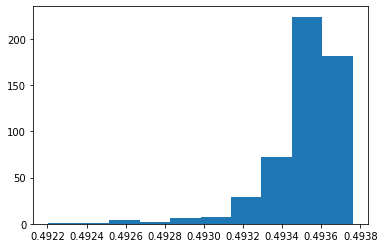

In [0]:
plt.hist(predictions_lstm_attention)
plt.show()

In [0]:
predictions_lstm_attention

array([[0.4961562 ],
       [0.49609172],
       [0.49615976],
       [0.49607486],
       [0.4961688 ],
       [0.49612573],
       [0.49614757],
       [0.4961554 ],
       [0.4961159 ],
       [0.49597448],
       [0.49617523],
       [0.49607423],
       [0.49605054],
       [0.4961135 ],
       [0.49616486],
       [0.49596468],
       [0.4961772 ],
       [0.49618816],
       [0.49549094],
       [0.49612513],
       [0.4961008 ],
       [0.4961989 ],
       [0.49613893],
       [0.49606025],
       [0.49615124],
       [0.49605876],
       [0.4960235 ],
       [0.496061  ],
       [0.49608633],
       [0.49609944],
       [0.49620906],
       [0.49543896],
       [0.49595445],
       [0.4960561 ],
       [0.49603152],
       [0.49607995],
       [0.49614912],
       [0.49606827],
       [0.49612287],
       [0.4961007 ],
       [0.49611697],
       [0.4960754 ],
       [0.49570054],
       [0.49610198],
       [0.49594525],
       [0.49615216],
       [0.49611413],
       [0.496

In [0]:
lstm_attention.layers

In [0]:
for layer in lstm_attention.layers:
    print(layer.output)

Tensor("input_16:0", shape=(?, 1695), dtype=float32)
Tensor("embedding_24/embedding_lookup/Identity_1:0", shape=(?, 1695, 64), dtype=float32)
Tensor("lstm_24/transpose_1:0", shape=(?, 1695, 10), dtype=float32)
Tensor("dense_25/Tanh:0", shape=(?, 1695, 1), dtype=float32)
Tensor("flatten_24/Reshape:0", shape=(?, 1695), dtype=float32)
Tensor("activation_12/Softmax:0", shape=(?, 1695), dtype=float32)
Tensor("repeat_vector_12/Tile:0", shape=(?, 10, 1695), dtype=float32)
Tensor("permute_12/transpose:0", shape=(?, 1695, 10), dtype=float32)
Tensor("multiply_12/mul:0", shape=(?, 1695, 10), dtype=float32)
Tensor("lambda_12/Sum:0", shape=(?, 10), dtype=float32)
Tensor("dense_26/Sigmoid:0", shape=(?, 1), dtype=float32)


In [0]:
# create Bidirectional LSTM with Attention using Keras Functional API
def create_bi_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(embedded)
    # Attention
    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(2*HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)
    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(1, activation='sigmoid')(output_attention)
    bi_lstm_attention = Model(inputs=[_input], outputs=output, name="bi_lstm_attention")
    return bi_lstm_attention

In [0]:
bi_lstm_attention = create_bi_lstm_with_attention()
bi_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_attention.summary())

bi_lstm_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=1, batch_size=1024, class_weight=class_weights_dict)

Model: "bi_lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1695, 64)     8192        input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1695, 20)     6000        embedding_27[0][0]               
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1695, 1)      21          bidirectional_2[0][0]            
__________________________________________________________________________________

In [0]:
for layer in bi_lstm_attention.layers:
    print(layer.output)

Tensor("input_19:0", shape=(?, 1695), dtype=float32)
Tensor("embedding_27/embedding_lookup/Identity_1:0", shape=(?, 1695, 64), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(?, 1695, 20), dtype=float32)
Tensor("dense_30/Tanh:0", shape=(?, 1695, 1), dtype=float32)
Tensor("flatten_28/Reshape:0", shape=(?, 1695), dtype=float32)
Tensor("activation_15/Softmax:0", shape=(?, 1695), dtype=float32)
Tensor("repeat_vector_15/Tile:0", shape=(?, 20, 1695), dtype=float32)
Tensor("permute_15/transpose:0", shape=(?, 1695, 20), dtype=float32)
Tensor("multiply_15/mul:0", shape=(?, 1695, 20), dtype=float32)
Tensor("lambda_13/Sum:0", shape=(?, 20), dtype=float32)
Tensor("dense_31/Sigmoid:0", shape=(?, 1), dtype=float32)


In [0]:
predictions_bi_lstm_attention, rounded_bi_lstm_attention = evaluate_metrics(bi_lstm_attention, X_test, y_test)

Precision: 0.920303605313093
Recall: 1.0


In [0]:
predictions_bi_lstm_attention

array([[0.49279505],
       [0.49278334],
       [0.49282378],
       [0.49290022],
       [0.49274424],
       [0.49280027],
       [0.49284464],
       [0.49289772],
       [0.49282852],
       [0.49298853],
       [0.49282432],
       [0.4929398 ],
       [0.49289438],
       [0.49284768],
       [0.4928056 ],
       [0.49273527],
       [0.4928078 ],
       [0.49285936],
       [0.49352923],
       [0.49284142],
       [0.4928773 ],
       [0.49280974],
       [0.49281394],
       [0.49290928],
       [0.4928471 ],
       [0.4927938 ],
       [0.49299645],
       [0.49297532],
       [0.49281278],
       [0.4928103 ],
       [0.49279988],
       [0.49309644],
       [0.49296218],
       [0.49295136],
       [0.4928891 ],
       [0.49289304],
       [0.4927944 ],
       [0.49284866],
       [0.49278468],
       [0.4928492 ],
       [0.49282867],
       [0.4928429 ],
       [0.49317837],
       [0.49278235],
       [0.4929482 ],
       [0.49283925],
       [0.4927866 ],
       [0.492

In [21]:
# MLP
MLP_HIDDEN_SIZE = 64

mlp = Sequential()
mlp.add(Input(shape=(MAX_LENGTH,)))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))  # 'tanh'
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))  # 'tanh'

mlp.add(Dense(1, activation='sigmoid'))

# adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mlp.summary())

mlp.fit(X_train, y_train,
                        #  validation_data=(X_train_val, y_train_val),
                         epochs=50, batch_size=64, class_weight=class_weights_dict)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                108544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 116,929
Trainable params: 116,929
Non-trainable params: 0
_________________________________________________________________
None
Train on 2104 samples
Epoch 1/50
2104/2104 [==============================] - 0s 116us/sample - loss: 1.9719 

In [22]:
predictions_mlp, rounded_mlp = evaluate_metrics(mlp, X_test, y_test)

Precision: 0.963963963963964
Recall: 0.44123711340206184
Balanced Accuracy: 0.6253804614629357
